# 03. Learning LangGraph - Agent Supervisor

In [1]:
# !pip install --quiet -U langchain langchain_openai langgraph langchainhub langchain_experimental

In [1]:
import os
# from google.colab import userdata


# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "LangGraph 03 Multi-agent Supervisor"

## The model

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4-1106-preview")

## Tools

In [3]:
from typing import Annotated, List, Tuple, Union
from langchain.tools import BaseTool, StructuredTool, Tool
from langchain_experimental.tools import PythonREPLTool
from langchain_core.tools import tool
import random

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [5]:
# my custom tools
@tool("lower_case", return_direct=False)
def to_lower_case(input:str) -> str:
  """Returns the input as all lower case."""
  return input.lower()

@tool("random_number", return_direct=False)
def random_number_maker(input:str) -> str:
    """Returns a random number between 0-100. input the word 'random'"""
    return random.randint(0, 100)

tools = [to_lower_case,random_number_maker,python_repl_tool]

## Helper Utils

In [6]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [7]:
# agent node
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

## Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

In [9]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Lotto_Manager", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

## Create the Agnet State and Graph

In [10]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


lotto_agent = create_agent(llm, tools, "You are a senior lotto manager. you run the lotto and get random numbers")
lotto_node = functools.partial(agent_node, agent=lotto_agent, name="Lotto_Manager")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(llm, [python_repl_tool], "You may generate safe python code to analyze data and generate charts using matplotlib.")
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Lotto_Manager", lotto_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

### Edges

In [11]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor") # add one edge for each of the agents

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

Run it

{'supervisor': {'next': 'Lotto_Manager'}}
----


Python REPL can execute arbitrary code. Use with caution.


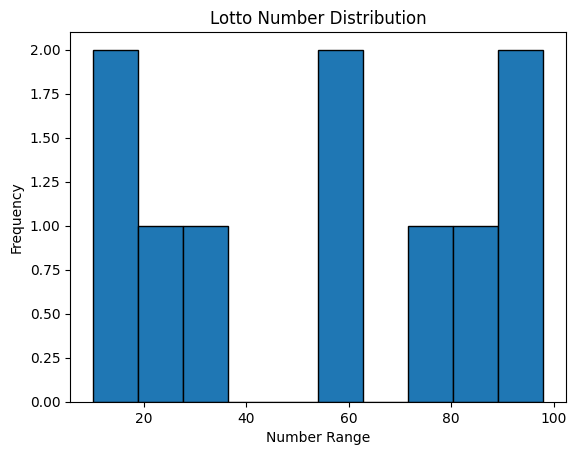

{'Lotto_Manager': {'messages': [HumanMessage(content='I have generated 10 random lotto numbers and plotted them on a histogram. Unfortunately, I cannot directly display the histogram here, but I can assure you that it has been created using the following numbers:\n\n1. 10\n2. 96\n3. 98\n4. 31\n5. 56\n6. 73\n7. 22\n8. 84\n9. 12\n10. 58\n\nThese numbers are distributed across 10 bins in the histogram to visualize their frequency.', name='Lotto_Manager')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [12]:
config = {"recursion_limit": 20}
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Get 10 random lotto numbers and plot them on a histogram in 10 bins and tell me what the 10 numbers are at the end")
        ]
    }, config=config
):
    if "__end__" not in s:
        print(s)
        print("----")

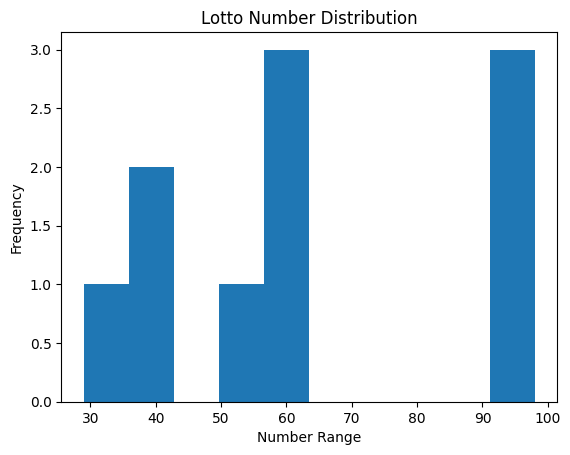

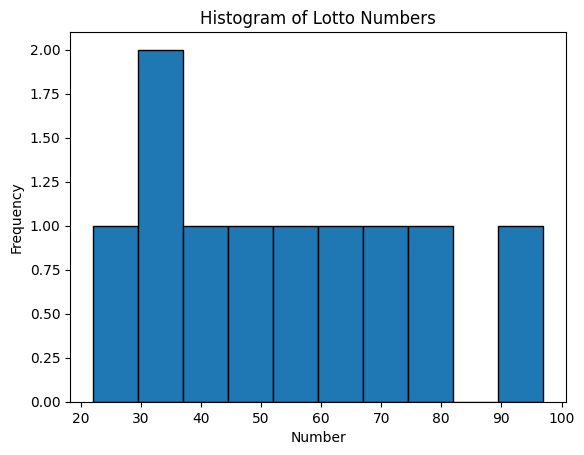

In [15]:
final_response = graph.invoke(
    {
        "messages": [
            HumanMessage(content="Get 10 random lotto numbers and plot them on a histogram in 10 bins and tell me what the 10 numbers are at the end")
        ]
    }, config=config
)

In [13]:
final_response

{'messages': [HumanMessage(content='Get 10 random lotto numbers and plot them on a histogram in 10 bins and tell me what the 10 numbers are at the end'),
  HumanMessage(content="I have generated 10 random lotto numbers and plotted them on a histogram. However, I'm unable to display the histogram here. To view the histogram, you would need to run the provided Python code in an environment where you can display plots, such as Jupyter Notebook or any Python IDE with plotting capabilities.\n\nHere are the 10 random lotto numbers:\n\n1. 89\n2. 81\n3. 60\n4. 31\n5. 53\n6. 56 (twice)\n7. 46\n8. 25\n9. 62\n\nTo create the histogram, you can use the following Python code:\n\n```python\nimport matplotlib.pyplot as plt\n\n# Lotto numbers\nlotto_numbers = [89, 81, 60, 31, 53, 56, 56, 46, 25, 62]\n\n# Create a histogram\nplt.hist(lotto_numbers, bins=10, edgecolor='black')\nplt.title('Lotto Numbers Histogram')\nplt.xlabel('Number Range')\nplt.ylabel('Frequency')\nplt.show()\n```\n\nThis code will pr

In [14]:
final_response['messages'][1].content

"I have generated 10 random lotto numbers and plotted them on a histogram. However, I'm unable to display the histogram here. To view the histogram, you would need to run the provided Python code in an environment where you can display plots, such as Jupyter Notebook or any Python IDE with plotting capabilities.\n\nHere are the 10 random lotto numbers:\n\n1. 89\n2. 81\n3. 60\n4. 31\n5. 53\n6. 56 (twice)\n7. 46\n8. 25\n9. 62\n\nTo create the histogram, you can use the following Python code:\n\n```python\nimport matplotlib.pyplot as plt\n\n# Lotto numbers\nlotto_numbers = [89, 81, 60, 31, 53, 56, 56, 46, 25, 62]\n\n# Create a histogram\nplt.hist(lotto_numbers, bins=10, edgecolor='black')\nplt.title('Lotto Numbers Histogram')\nplt.xlabel('Number Range')\nplt.ylabel('Frequency')\nplt.show()\n```\n\nThis code will produce a histogram with 10 bins, each representing the frequency of the lotto numbers within a certain range."

: 